# Visual image search
_**Using a Convolutional Neural Net and Elasticsearch k-Nearest Neighbors Index to retrieve visually similar images**_

---

---

## Contents


1. [Background](#Background)
1. [Setup](#Setup)
1. [GluonCV(MXNet) Model Preparation](#GluonCV(MXNet)-Model-Preparation)
1. [SageMaker Model Hosting](#Hosting-Model)
1. [SageMaker Model Hosting (BYOC)](#Hosting-Model-BYOC)
1. [Build a KNN Index in Elasticsearch](#ES-KNN)
1. [Evaluate Index Search Results](#Searching-with-ES-k-NN)
1. [Extensions](#Extensions)

## Background

In this notebook, we'll build the core components of a visual image search application. Visual image search is used in interfaces where instead of asking for something by voice or text, you show a photographic example of what you are looking for.

One of the core components of visual image search is a convolutional neural net (CNN) model that generates “feature vectors” representing both a query image and the reference item images to be compared against the query. The reference item feature vectors typically are generated offline and must be stored in a database of some sort, so they can be efficiently searched. For small reference item datasets, it is possible to use a brute force search that compares the query against every reference item. However, this is not feasible for large data sets where brute force search would become prohibitively slow. 

To enable efficient searches for visually similar images, we'll use Amazon SageMaker to generate “feature vectors” from images and use KNN algorithm in Amazon Elasticsearch Service. KNN for Amazon Elasticsearch Service lets you search for points in a vector space and find the "nearest neighbors" for those points by Euclidean distance or cosine similarity(default is Euclidean distance). Use cases include recommendations (for example, an "other songs you might like" feature in a music application), image recognition, and fraud detection.

Here are the steps we'll follow to build the visual image search: After some initial setup, we'll prepare a model using TensorFlow for generating feature vectors, then generate feature vectors of Fashion Images from *__feidegger__*, a *__zalandoresearch__* dataset. Those feature vectors will be imported in Amazon Elasticsearch KNN Index. Next, we'll explore some test image queries, and visualize the results.


In [ ]:
#Install tqdm to have progress bar
!pip install tqdm -i https://opentuna.cn/pypi/web/simple

#install necessary pkg to make connection with elasticsearch domain
!pip install elasticsearch -i https://opentuna.cn/pypi/web/simple
!pip install requests -i https://opentuna.cn/pypi/web/simple
!pip install requests-aws4auth -i https://opentuna.cn/pypi/web/simple

!pip install gluoncv -i https://opentuna.cn/pypi/web/simple

In [2]:
import boto3
import re
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

s3_resource = boto3.resource("s3")
s3 = boto3.client('s3')

In [44]:
cfn = boto3.client('cloudformation')

def get_cfn_outputs(stackname):
    outputs = {}
    for output in cfn.describe_stacks(StackName=stackname)['Stacks'][0]['Outputs']:
        outputs[output['OutputKey']] = output['OutputValue']
    return outputs

## Setup variables to use for the rest of the demo
cloudformation_stack_name = "vis-search-cn"

outputs = get_cfn_outputs(cloudformation_stack_name)

bucket = outputs['s3BucketTraining']
es_host = outputs['esHostName']

outputs

{'esDomainName': 'vis-sea-domain-53ry8ji4t6t4',
 'S3BucketSecureURL': 'https://vis-search-cn-s3buckethosting-p9ceusr8e6mz.s3.amazonaws.com',
 'esHostName': 'search-vis-sea-domain-53ry8ji4t6t4-uz3t7sea53wgxf2pgwy3y2qo7e.cn-northwest-1.es.amazonaws.com.cn',
 'SageMakerNotebookURL': 'https://console.amazonaws.cn/sagemaker/home?region=cn-northwest-1#/notebook-instances/openNotebook/NotebookInstance-tjlOReBKZ2wY?view=classic',
 's3BucketTraining': 'vis-search-cn-s3buckettraining-cpoc5qtnqwf2',
 's3BucketHostingBucketName': 'vis-search-cn-s3buckethosting-p9ceusr8e6mz'}

In [ ]:
!aws s3 cp --recursive images $bucket/images

## GluonCV(MXNet) Model Preparation

We'll use MXNet backend to prepare a model for "featurizing" images into feature vectors. MXNet has a native Module API, as well as a higher level Gluon API. 

We will start with a pretrained model, avoiding spending time and money training a model from scratch. Accordingly, as a first step in preparing the model, we'll import a pretrained model from GluonCV application. Researchers have experimented with various pretrained CNN architectures with different numbers of layers, discovering that there are several good possibilities.

In this notebook, we'll select a model based on the ResNet architecture, a commonly used choice. Of the various choices for number of layers, ranging from 18 to 152, we'll use 50 layers. This also is a common choice that balances the expressiveness of the resulting feature vectors (embeddings) against computational efficiency (lower number of layers means greater efficiency at the cost of less expressiveness).

In [4]:
import mxnet as mx
from mxnet.gluon import nn
from mxnet import gluon, image, init, nd
from gluoncv.model_zoo import get_model
from gluoncv.data.transforms.presets.imagenet import transform_eval

In [5]:
num_gpus = 0
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]

model_name = 'ResNet50_v2'
classes = 8

finetune_net = get_model(model_name, pretrained=True)
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)
finetune_net.output.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

92863KB [00:08, 11268.16KB/s]                           


In [6]:
input_pic = 'endpoint/1.jpg'

# Load Images
img = image.imread(input_pic)

# Transform
img = transform_eval(img).copyto(ctx[0])
    
finetune_net(img)


[[ 0.57350737 -0.7944516  -1.4665352  -0.7336704  -0.56196624  0.38793743
  -0.8004254   0.5354174 ]]
<NDArray 1x8 @cpu(0)>

Now we'll get a reference ResNet50 model which is trained on Imagenet dataset to extract the feature without the actual clssifier. More specifically, we'll use that layer to generate a row vector of floating point numbers as an "embedding" or representation of the features of the image. We'll also save the model as *SavedModel* format under **export/Servo/1** to serve from SageMaker MXNet serving API.

In [7]:
!mkdir -p endpoint/model

In [8]:
finetune_net.save_parameters('endpoint/model/model-0000.params')

## SageMaker Model Hosting

After saving the feature extractor model we will deploy the model using Sagemaker Tensorflow Serving api which is a flexible, high-performance serving system for machine learning models, designed for production environments.TensorFlow Serving makes it easy to deploy new algorithms and experiments, while keeping the same server architecture and APIs. TensorFlow Serving provides out-of-the-box integration with TensorFlow models, but can be easily extended to serve other types of models and data. We will define **inference.py** to customize the input data to TensorFlow serving API. We also need to add **requirements.txt** file for aditional libraby in the tensorflow serving container.

In [ ]:
# #check the actual content of inference.py
# !pygmentize endpoint/inference.py

In [ ]:
# import tarfile

# #zip the model .gz format
# export_dir = ''
# with tarfile.open('model.tar.gz', mode='w:gz') as archive:
#     archive.add('export', recursive=True)

In [ ]:
# #Upload the model to S3
# sagemaker_session = sagemaker.Session()
# inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')
# inputs

After we upload the model to S3 we will use TensorFlow serving container to host the model. We are using ml.p3.16xlarge instance type. You may need to raise support ticket to increase the Service quotas for SageMaker hosting instance type. We will use this endpoint to generate features and import into ElasticSearch. you can also choose small instance such as "ml.m4.xlarge" to save cost.

In [ ]:
# #Deploy the model in Sagemaker Endpoint. This process will take ~10 min.
# from sagemaker.tensorflow.serving import Model

# sagemaker_model = Model(entry_point='inference.py', model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
#                                   role = role, framework_version='2.1.0', source_dir='./src' )

# predictor = sagemaker_model.deploy(initial_instance_count=3, instance_type='ml.m5.xlarge')



In [ ]:
# # get the features for a sample image
# payload = s3.get_object(Bucket=bucket,Key='image-embedding/1.jpg')['Body'].read()
# predictor.content_type = 'application/x-image'
# predictor.serializer   = None
# features = predictor.predict(payload)['predictions'][0]

# features



## SageMaker Model Hosting (BYOC)
```
cd endpoint
./build_and_push.sh image-embedding
python create_endpoint.py
docker run -v -d -p 8080:8080 image-embedding
python test.py
```

## Build a KNN Index in Elasticsearch

KNN for Amazon Elasticsearch Service lets you search for points in a vector space and find the "nearest neighbors" for those points by Euclidean distance or cosine similarity (default is Euclidean distance). Use cases include recommendations (for example, an "other songs you might like" feature in a music application), image recognition, and fraud detection.

KNN requires Elasticsearch 7.1 or later. Full documentation for the Elasticsearch feature, including descriptions of settings and statistics, is available in the Open Distro for Elasticsearch documentation. For background information about the k-nearest neighbors algorithm

In this step we'll get all the features zalando images and import those features into Elastichseach7.4 domain.

In [45]:
#Define some utility function

#return all s3 keys
def get_all_s3_keys(bucket):
    """Get a list of all keys in an S3 bucket."""    
    keys = []

    kwargs = {'Bucket': bucket}
    while True:
        resp = s3.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            if obj['Key'].endswith('.jpg'):
                keys.append('s3://' + bucket + '/' + obj['Key'])

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

    return keys

In [46]:
# get all the zalando images keys from the bucket make a list
s3_uris = get_all_s3_keys(bucket)

In [47]:
len(s3_uris)

11888

In [49]:
s3_uris[:10]

['s3://vis-search-cn-s3buckettraining-cpoc5qtnqwf2/images/卫生间/.ipynb_checkpoints/15315-checkpoint.jpg',
 's3://vis-search-cn-s3buckettraining-cpoc5qtnqwf2/images/卫生间/.ipynb_checkpoints/2401-checkpoint.jpg',
 's3://vis-search-cn-s3buckettraining-cpoc5qtnqwf2/images/卫生间/15315.jpg',
 's3://vis-search-cn-s3buckettraining-cpoc5qtnqwf2/images/卫生间/2401.jpg',
 's3://vis-search-cn-s3buckettraining-cpoc5qtnqwf2/images/卫生间/2402.jpg',
 's3://vis-search-cn-s3buckettraining-cpoc5qtnqwf2/images/卫生间/2403.jpg',
 's3://vis-search-cn-s3buckettraining-cpoc5qtnqwf2/images/卫生间/2404.jpg',
 's3://vis-search-cn-s3buckettraining-cpoc5qtnqwf2/images/卫生间/2405.jpg',
 's3://vis-search-cn-s3buckettraining-cpoc5qtnqwf2/images/卫生间/2406.jpg',
 's3://vis-search-cn-s3buckettraining-cpoc5qtnqwf2/images/卫生间/2407.jpg']

In [50]:
# define a function to extract image features
from time import sleep
import json

sm_client = boto3.client('sagemaker-runtime')
ENDPOINT_NAME = 'image-embedding'  # predictor.endpoint

def get_predictions(payload):
    return sm_client.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                           ContentType='application/json',  # 'application/x-image'
                                           Body=payload)

def extract_features(s3_uri):
    key = s3_uri.replace(f's3://{bucket}/', '')
    payload = json.dumps({'bucket' : bucket, 'image_uri' : key, 'content_type': "application/json"})  # s3.get_object(Bucket=bucket,Key=key)['Body'].read()
    try:
        response = get_predictions(payload)
    except:
        sleep(0.1)
        response = get_predictions(payload)

    del payload
    response_body = json.loads((response['Body'].read()))
    feature_lst = response_body  # response_body['predictions'][0]
    
    return s3_uri, feature_lst


In [51]:
resulti = extract_features(s3_uris[0])
print(resulti)

('s3://vis-search-cn-s3buckettraining-cpoc5qtnqwf2/images/卫生间/.ipynb_checkpoints/15315-checkpoint.jpg', [0.011275135912001133, 0.11010532826185226, 0.34398382902145386, 0.16001738607883453, 0.4453515410423279, 0.09874645620584488, 0.07961580902338028, 0.3785952627658844, 0.00036034785443916917, 0.17278321087360382, 0.1072838231921196, 0.00286406883969903, 0.0, 0.09365902841091156, 0.40293803811073303, 0.314220666885376, 0.4924561381340027, 0.0, 0.3468118906021118, 0.20829109847545624, 0.561301589012146, 0.12108898907899857, 0.08890348672866821, 0.5227836966514587, 0.8754441142082214, 0.41142043471336365, 0.10320618748664856, 0.15061698853969574, 0.08475027233362198, 0.2802658975124359, 0.5141303539276123, 0.09984773397445679, 0.2635346055030823, 0.018795575946569443, 0.2571336328983307, 0.3030344843864441, 1.2535746097564697, 0.4031841456890106, 0.6954056620597839, 0.0905972272157669, 0.8595625162124634, 0.05209362879395485, 1.1699060201644897, 0.47335729002952576, 0.4107153117656708, 

In [52]:
# This process cell will take approximately 24-25 minutes on a t3.medium notebook instance
# with 3 m5.xlarge SageMaker Hosted Endpoint instances
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map

workers = 1  # 2 * cpu_count()
result = process_map(extract_features, s3_uris[:100], max_workers=workers)

  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
# setting up the Elasticsearch connection
from elasticsearch import Elasticsearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
region = 'cn-northwest-1' # e.g. us-east-1
service = 'es'
credentials = boto3.Session().get_credentials()
awsauth = AWS4Auth(credentials.access_key, credentials.secret_key, region, service, session_token=credentials.token)

es = Elasticsearch(
    hosts = [{'host': es_host, 'port': 443}],
    http_auth = awsauth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection
)

In [54]:
#Define KNN Elasticsearch index maping
knn_index = {
    "settings": {
        "index.knn": True
    },
    "mappings": {
        "properties": {
            "zalando_img_vector": {
                "type": "knn_vector",
                "dimension": 2048
            }
        }
    }
}

In [55]:
#Creating the Elasticsearch index
es.indices.create(index="idx_zalando",body=knn_index,ignore=400)
es.indices.get(index="idx_zalando")

{'idx_zalando': {'aliases': {},
  'mappings': {'properties': {'image': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'zalando_img_vector': {'type': 'knn_vector', 'dimension': 2048}}},
  'settings': {'index': {'number_of_shards': '5',
    'provided_name': 'idx_zalando',
    'knn': 'true',
    'creation_date': '1618333575857',
    'number_of_replicas': '1',
    'uuid': 'ZVpA8FzERpOhyd6-SUaEZw',
    'version': {'created': '7040299'}}}}}

In [ ]:
# defining a function to import the feature vectors corrosponds to each S3 URI into Elasticsearch KNN index
# This process will take around ~3 min.


def es_import(i):
    es.index(index='idx_zalando',
             body={"zalando_img_vector": i[1], 
                   "image": i[0]}
            )
    
_ = process_map(es_import, result, max_workers=workers)

## Evaluate Index Search Results

In this step we will use SageMaker SDK as well as Boto3 SDK to query the Elasticsearch to retrive the nearest neighbours. One thing to mention **zalando** dataset has pretty good similarity with Imagenet dataset. Now if you hav a very domain speific problem then then you need to train that dataset on top of pretrained feature extractor model such as VGG, Resnet, Xeception, Mobilenet etc and bulid a new feature extractor model.

In [58]:
#define display_image function
def display_image(bucket, key):
    response = s3.get_object(Bucket=bucket,Key=key)['Body']
    img = Image.open(response)
    return display(img)

In [59]:
import requests
import random
from PIL import Image
import io
# urls = []
# # yellow pattern dess
# urls.append('https://fastly.hautelookcdn.com/products/D7242MNR/large/13494318.jpg')
# # T shirt kind dress
# urls.append('https://fastly.hautelookcdn.com/products/M2241/large/15658772.jpg')
# #Dotted pattern dress
# urls.append('https://fastly.hautelookcdn.com/products/19463M/large/14537545.jpg')

# img_bytes = requests.get(random.choice(urls)).content
# query_img = Image.open(io.BytesIO(img_bytes))
# query_img

###### SageMaker SDK Method

In [60]:
#SageMaker SDK approach
# predictor.content_type = 'application/x-image'
# predictor.serializer   = None
# features = predictor.predict(img_bytes)['predictions'][0]

# Boto3 approach
tmp_bucket = 'sagemaker-cn-northwest-1-343958593302'
s3_uri = f's3://{tmp_bucket}/image-embedding/1.jpg'
key = s3_uri.replace(f's3://{tmp_bucket}/', '')
payload = json.dumps({'bucket' : tmp_bucket, 'image_uri' : key, 'content_type': "application/json"})  # s3.get_object(Bucket=bucket,Key=key)['Body'].read()
response = get_predictions(payload)
response_body = json.loads((response['Body'].read()))
features = response_body  # response_body['predictions'][0]

In [61]:
import json
k = 5
idx_name = 'idx_zalando'
res = es.search(request_timeout=30, index=idx_name,
                body={'size': k, 
                      'query': {'knn': {'zalando_img_vector': {'vector': features, 'k': k}}}})

images/卫生间/2589.jpg


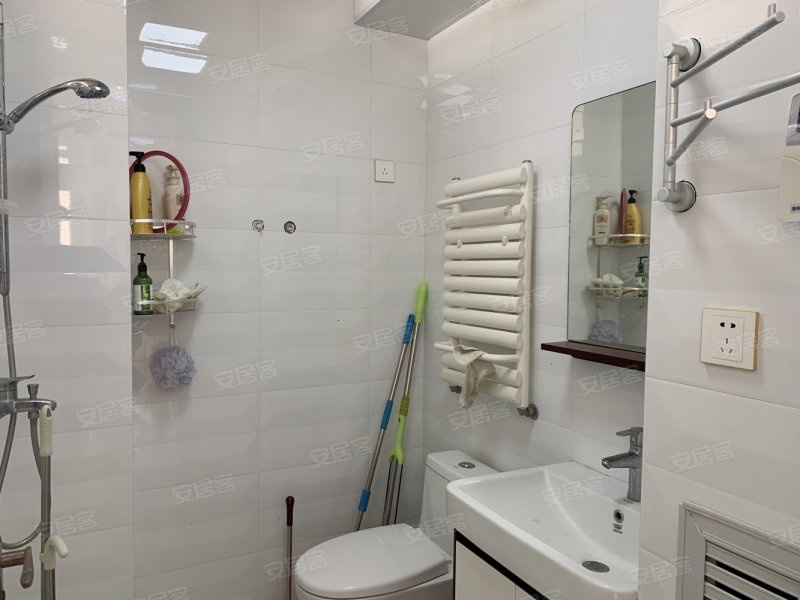

images/卫生间/2410.jpg


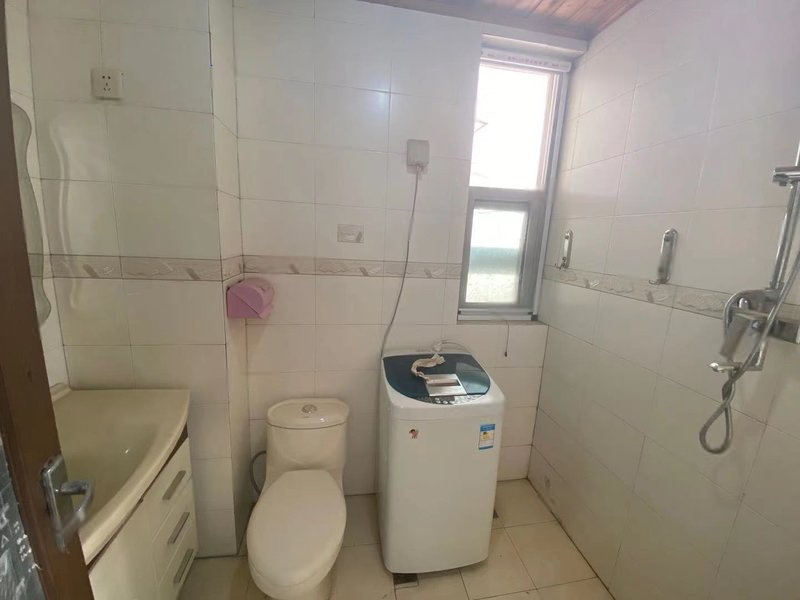

images/卫生间/2410.jpg


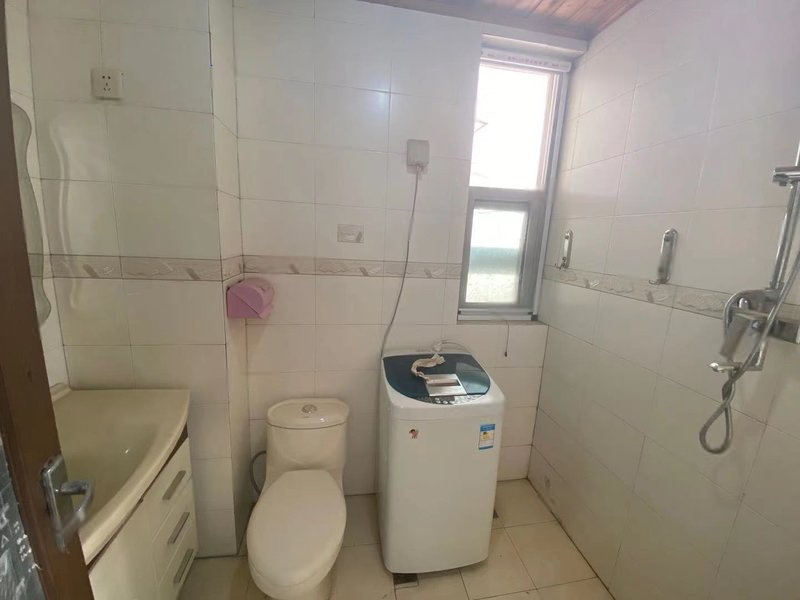

images/卫生间/2410.jpg


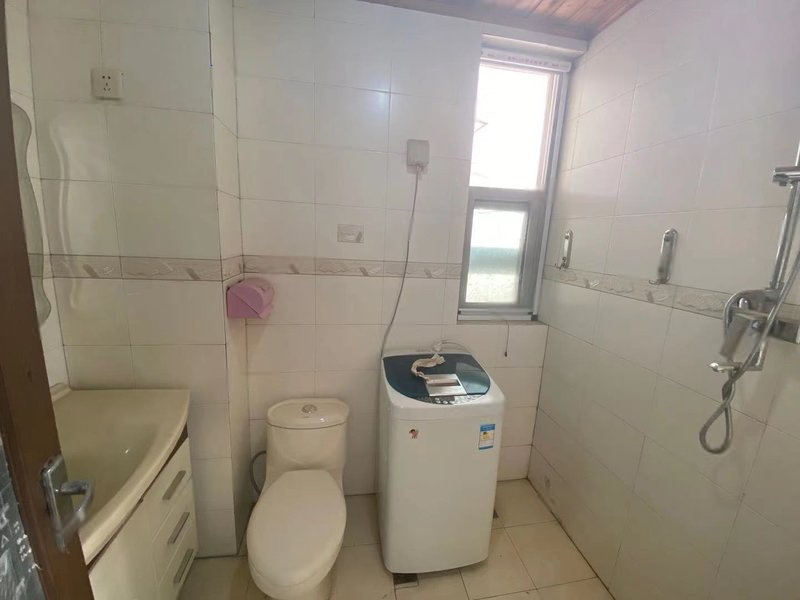

images/卫生间/2661.jpg


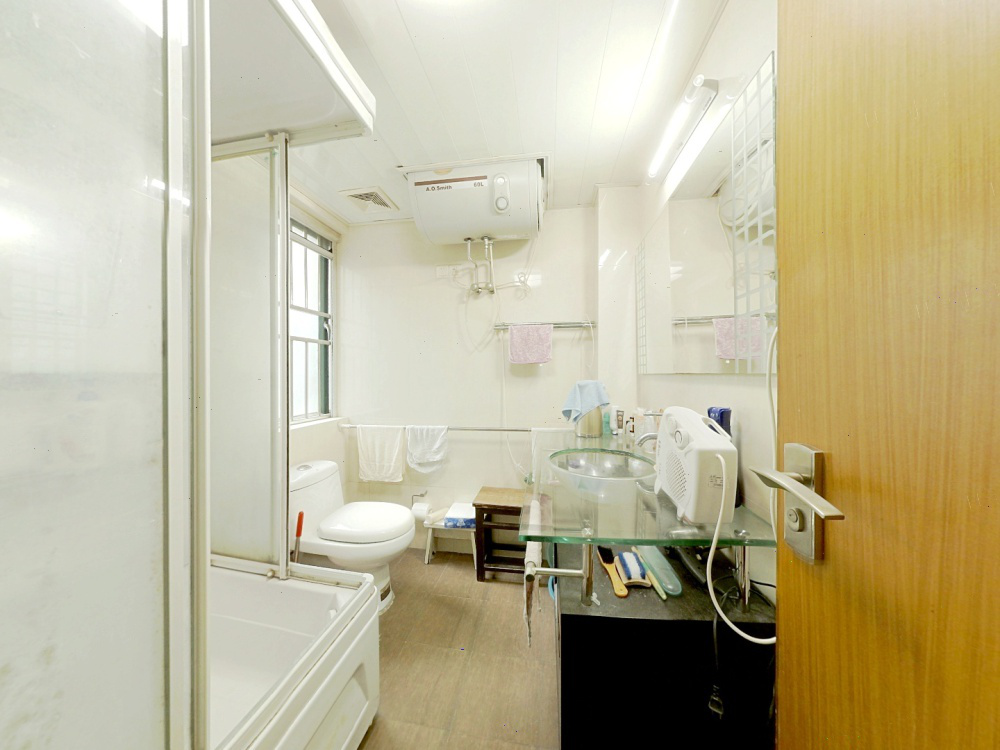

In [69]:
for i in range(k):
    key = res['hits']['hits'][i]['_source']['image']
    key = key.replace(f's3://{bucket}/','')
    if key.startswith('s3'):
        key = 'images'+key.replace('s3://app-5i5j/data/test', '').replace('s3://app-5i5j/data/train', '').replace('s3://app-5i5j', '')
    print(key)
    img = display_image(bucket,key)

# Deploying a full-stack visual search application

In [ ]:
s3_resource.Object(bucket, 'backend/template.yaml').upload_file('./backend/template.yaml', ExtraArgs={'ACL':'public-read'})


sam_template_url = f'https://{bucket}.s3.amazonaws.com/backend/template.yaml'

# Generate the CloudFormation Quick Create Link

print("Click the URL below to create the backend API for visual search:\n")
print((
    'https://console.aws.amazon.com/cloudformation/home?region=us-east-1#/stacks/create/review'
    f'?templateURL={sam_template_url}'
    '&stackName=vis-search-api'
    f'&param_BucketName={outputs["s3BucketTraining"]}'
    f'&param_DomainName={outputs["esDomainName"]}'
    f'&param_ElasticSearchURL={outputs["esHostName"]}'
    f'&param_SagemakerEndpoint={predictor.endpoint}'
))

Now that you have a working Amazon SageMaker endpoint for extracting image features and a KNN index on Elasticsearch, you are ready to build a real-world full-stack ML-powered web app. The SAM template you just created will deploy an Amazon API Gateway and AWS Lambda function. The Lambda function runs your code in response to HTTP requests that are sent to the API Gateway.

In [ ]:
# Review the content of the Lambda function code.
!pygmentize backend/lambda/app.py

### Once the CloudFormation Stack shows CREATE_COMPLETE, proceed to this cell below:

In [ ]:
# Save the REST endpoint for the search API to a config file, to be used by the frontend build

import json
api_endpoint = get_cfn_outputs('vis-search-api')['ImageSimilarityApi']

with open('./frontend/src/config/config.json', 'w') as outfile:
    json.dump({'apiEndpoint': api_endpoint}, outfile)

## Step 2: Deploy frontend services

In [ ]:
# add NPM to the path so we can assemble the web frontend from our notebook code

from os import environ

npm_path = ':/home/ec2-user/anaconda3/envs/JupyterSystemEnv/bin'

if npm_path not in environ['PATH']:
    ADD_NPM_PATH = environ['PATH']
    ADD_NPM_PATH = ADD_NPM_PATH + npm_path
else:
    ADD_NPM_PATH = environ['PATH']
    
%set_env PATH=$ADD_NPM_PATH

In [ ]:
%cd ./frontend/

!npm install

In [ ]:
!npm run-script build

In [ ]:
hosting_bucket = f"s3://{outputs['s3BucketHostingBucketName']}"

!aws s3 sync ./build/ $hosting_bucket --acl public-read

## Step 3: Browse your frontend service, and upload an image

In [ ]:
print('Click the URL below:\n')
print(outputs['S3BucketSecureURL'] + '/index.html')

You should see the following page:

![Website](pi3small.png)

On the website, try pasting the following URL in the URL text field.

`https://i4.ztat.net/large/VE/12/1C/14/8K/12/VE121C148-K12@10.jpg`

## Extensions

We have used pretrained Resnet50 model which is trained on Imagenet dataset. Now based on your use-case you can fine tune any pre-trained models, such as VGG, Inception, and MobileNet with your own dataset and host the model in Amazon SageMaker.

You can also use Amazon SageMaker Batch transform job to have a bulk feaures extracted from your stored S3 images and then you can use AWS Glue to import that data into Elasticeearch domain.


### Cleanup

Make sure that you stop the notebook instance, delete the Amazon SageMaker endpoint and delete the Elasticsearch domain to prevent any additional charges.

In [ ]:
# Delete the endpoint
predictor.delete_endpoint()

In [ ]:
# Empty S3 Contents
training_bucket_resource = s3_resource.Bucket(bucket)
training_bucket_resource.objects.all().delete()

hosting_bucket_resource = s3_resource.Bucket(outputs['s3BucketHostingBucketName'])
hosting_bucket_resource.objects.all().delete()